In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# 與Google Colab連結

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_trans = pd.read_csv('/content/drive/My Drive/Untitled folder/dataset/train_transaction.csv')
test_trans = pd.read_csv('/content/drive/My Drive/Untitled folder/dataset/test_transaction.csv')

# 降低DataFrame的Memory

Memory Usage (調整前): <br>


train_trans: 2.1 GB <br> 
test_trans: 1.8 GB

Reference: https://medium.com/@aakashgoel12/avoid-memory-error-techniques-to-reduce-dataframe-memory-usage-fcf53b2318a2

###根据數值範圍決定要調整成何種數據類型('float16/ float32/ float64)'


In [ ]:
# Check the range of float32 and see if it fits data.

#print('Float32 range: ', np.finfo('float32'))

float32_max, float32_min = np.finfo('float32').max, np.finfo('float32').min
within = 0
f_col = 0
for col in train_trans.columns:
    if 'float64' in str(train_trans[col].dtypes):
        f_col += 1
        l = train_trans[col].fillna(0)
        if f_col % 50 == 0:
            print('col: ', col, ', min: ', min(l),', max: ', max(l))
        if not float32_min < min(l) and float32_max > max(l):           
            
            print()
            print('Out of the range!!!!!')
            print('==============================================================================')
        else:
            if f_col % 50 == 0:
                print('Within the range.')
                print('==============================================================================')
            within += 1
            train_trans[col] = train_trans[col].astype('float32')
            
print('If all within the range: ', within == f_col)
            


col:  V13 , min:  0.0 , max:  6.0
Within the range.
col:  V63 , min:  0.0 , max:  7.0
Within the range.
col:  V113 , min:  0.0 , max:  9.0
Within the range.
col:  V163 , min:  0.0 , max:  3300.0
Within the range.
col:  V213 , min:  0.0 , max:  97628.0
Within the range.
col:  V263 , min:  0.0 , max:  153600.0
Within the range.
col:  V313 , min:  0.0 , max:  4817.47021484375
Within the range.
If all within the range:  True


In [ ]:
# test_trans


float32_max, float32_min = np.finfo('float32').max, np.finfo('float32').min
within = 0
f_col = 0

for col in test_trans.columns:
    if 'float64' in str(test_trans[col].dtypes):
        f_col += 1
        l = test_trans[col].fillna(0)
        if f_col % 50 == 0:
            print('col: ', col, ', min: ', min(l),', max: ', max(l))
        if not float32_min < min(l) and float32_max > max(l):
                        
            
            print()
            print('Out of the range!!!!!')
            print('==============================================================================')
        else:
            if f_col % 50 == 0:
                print('Within the range.')
                print('==============================================================================')
            within += 1
            test_trans[col] = test_trans[col].astype('float32')
            
print('If all within the range: ', within == f_col)
            


col:  V13 , min:  0.0 , max:  6.0
Within the range.
col:  V63 , min:  0.0 , max:  8.0
Within the range.
col:  V113 , min:  0.0 , max:  8.0
Within the range.
col:  V163 , min:  0.0 , max:  4000.0
Within the range.
col:  V213 , min:  0.0 , max:  928882.0
Within the range.
col:  V263 , min:  0.0 , max:  1065496.5
Within the range.
col:  V313 , min:  0.0 , max:  4727.9599609375
Within the range.
If all within the range:  True


調整後

train_trans: 2.1 GB => 1.2 GB <br> 

test_trans: 1.8 GB => 1.1 MB

# 合併 Train/ Test Transactions Data 成 all_trans

In [ ]:
# # all_trans => train & test transaction data 

all_trans =  pd.concat([train_trans.drop(columns='isFraud'), test_trans], axis = 0)

all_trans.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

這是一個非常大的Dataset, Train Data有 590540 rows, 394 columns, Test Data有506691 rows, 393 columns。

In [ ]:
print('train_trans: ', train_trans.shape)
print('test_trans: ', test_trans.shape)

train_trans:  (590540, 394)
test_trans:  (506691, 393)


然而因為這是一個Fraud Detection的Dataset, 所以Label 0/ 1的占比是極為不平均的。我們會需要一些技巧(Sampling Techniques)去彌補這樣的情況，以提高模型的準確率。

In [ ]:
# Check label ratio 
# This is an imbalanced dataset

c = train_trans['isFraud'].value_counts()

for i, v in zip(c.index, c):
    total = sum(c)
    print('Label',i, ':', v, '|', (v/total)*100, '%' )

Label 0 : 569877 | 96.50099908558268 %
Label 1 : 20663 | 3.4990009144173126 %


In [ ]:
# Input: DataFrame, 以及要計算占比的feature
# Output: DataFrame, 顯示此feature中各個組別的占比

def turn_into_countdf(df, col):
    
    output = pd.DataFrame(df[col].value_counts(dropna = False), index =None).reset_index()
    whole = output[col].sum()
    output['pecentage'] = output[col].apply(lambda x: round(x/whole, 5))
    
    return output
    

### TransactionDT & D 的關係

從下圖中，我們可以清楚看到 D features與時間(TransactionDT)有著正向關係，因此在這裡我會將 D columns (D3~D15, 除了D9) Normalized。

Column  D1


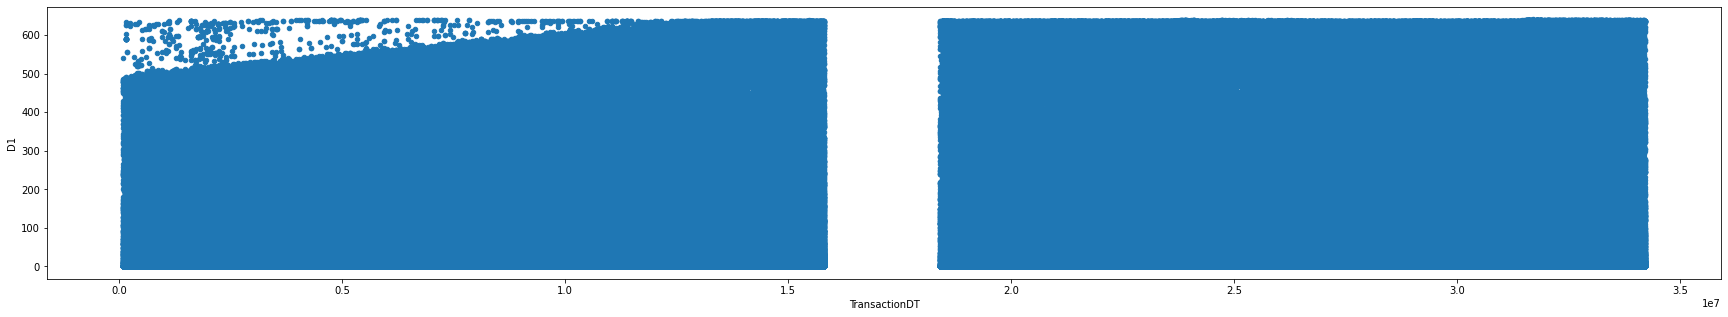

Column  D2


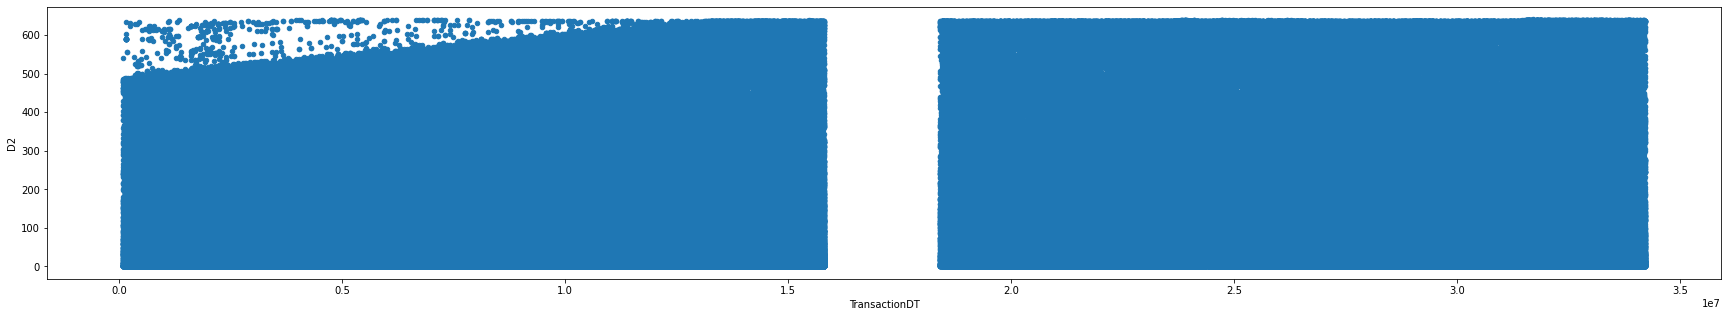

Column  D3


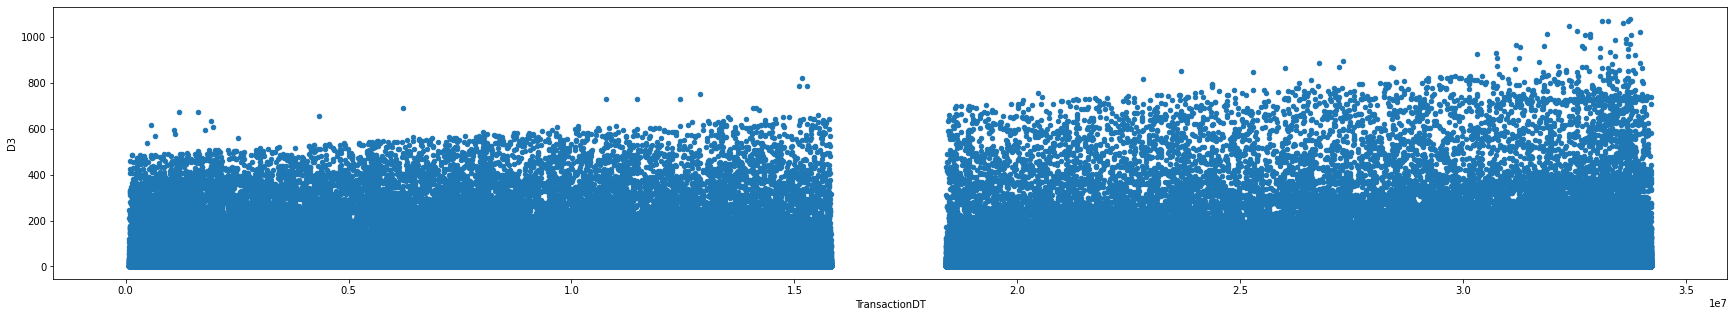

Column  D4


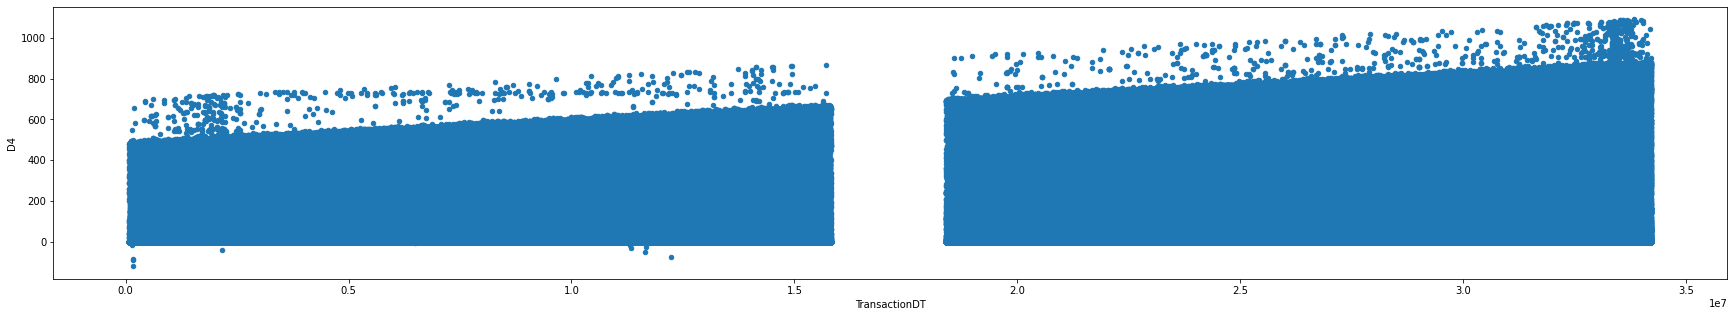

Column  D5


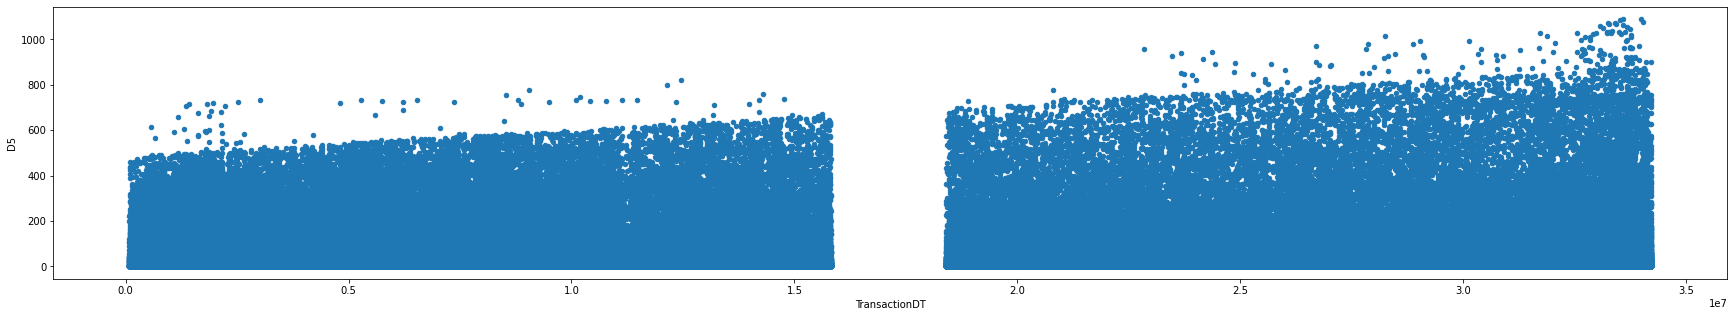

Column  D6


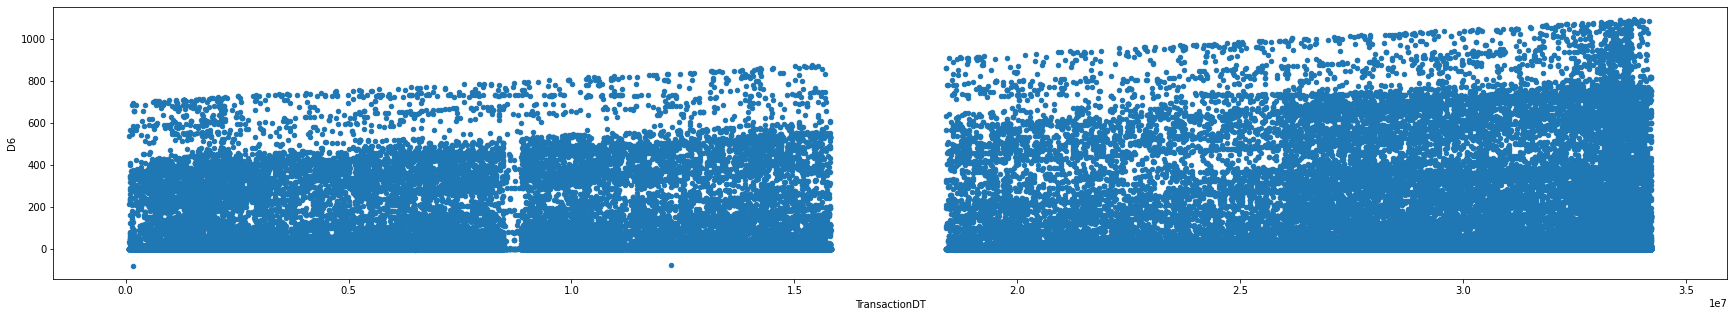

Column  D7


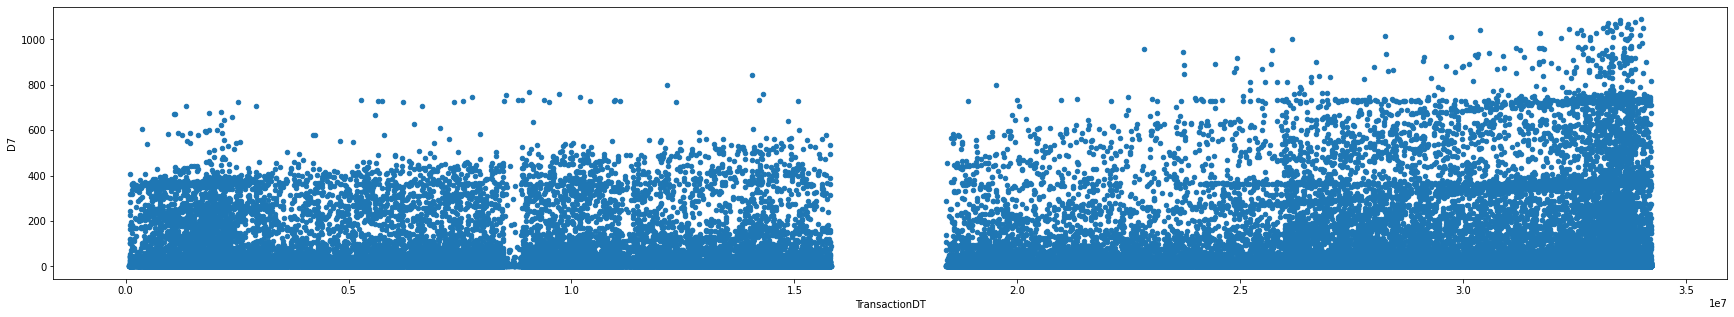

Column  D8


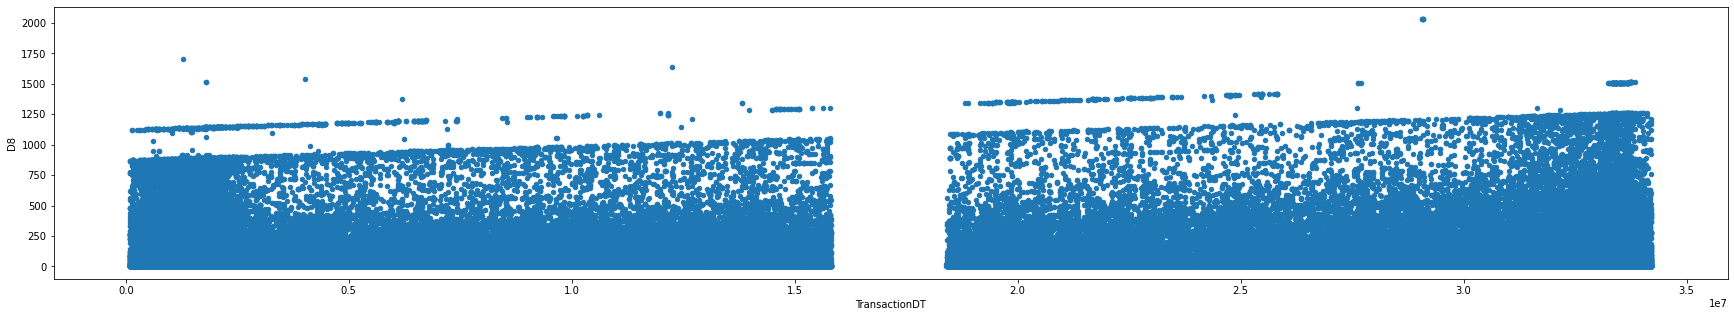

Column  D9


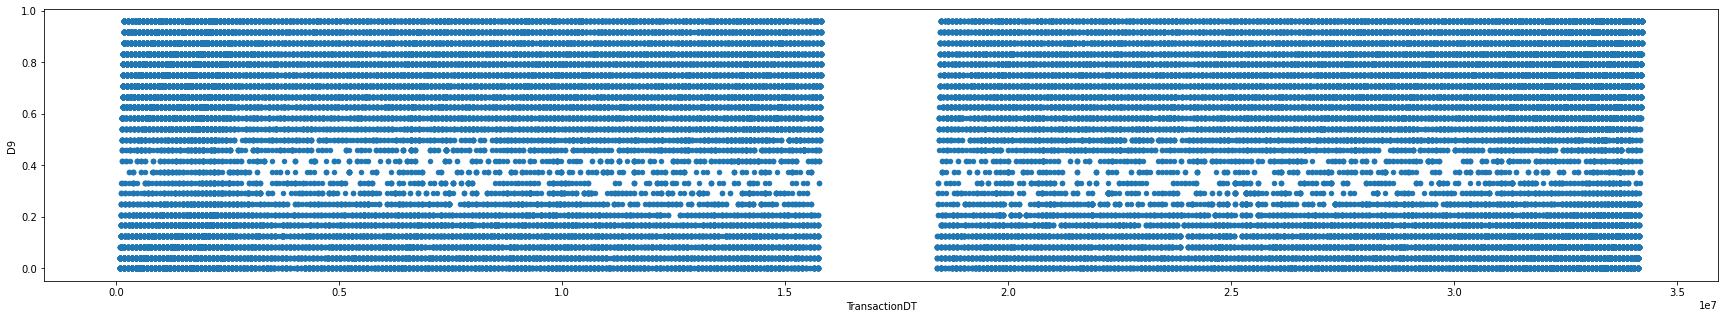

Column  D10


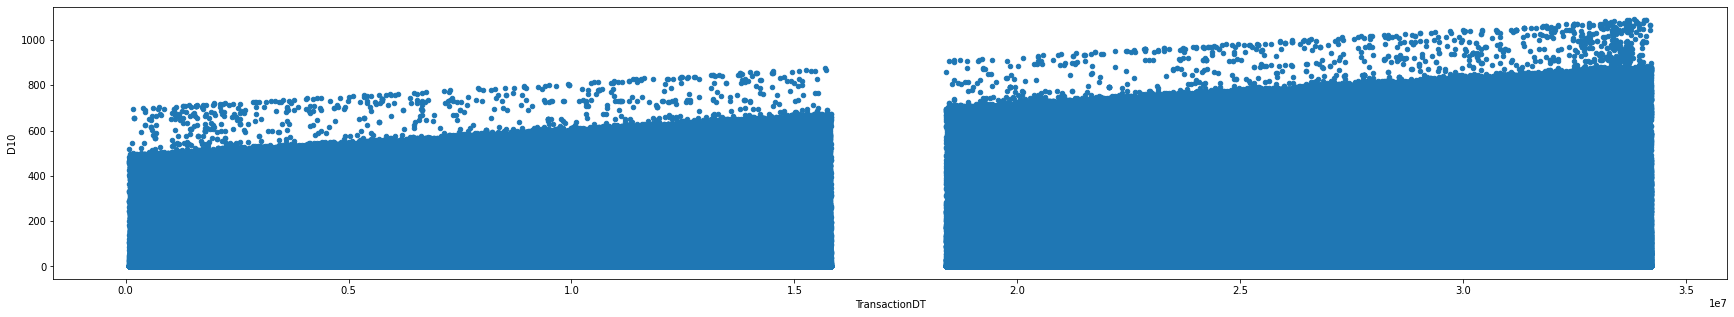

Column  D11


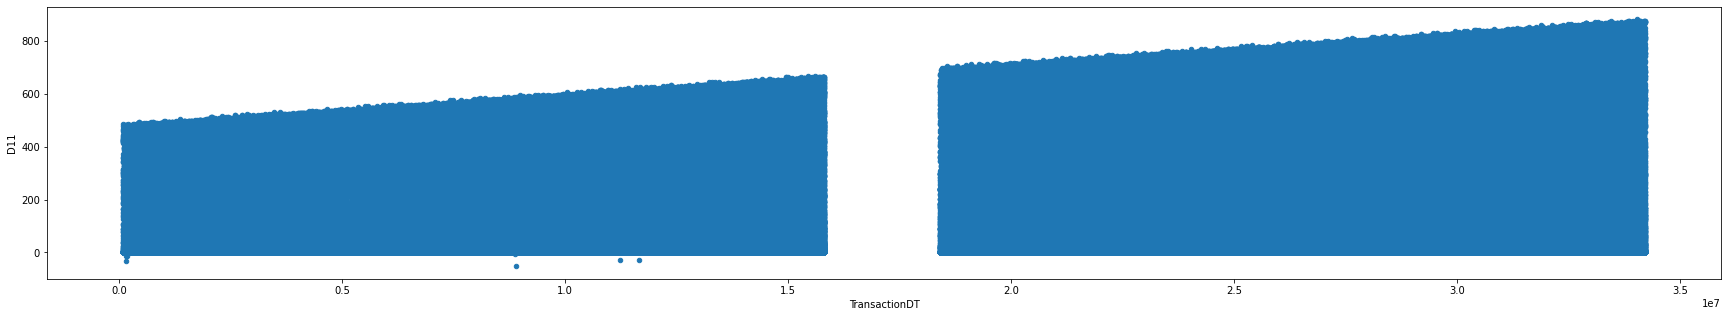

Column  D12


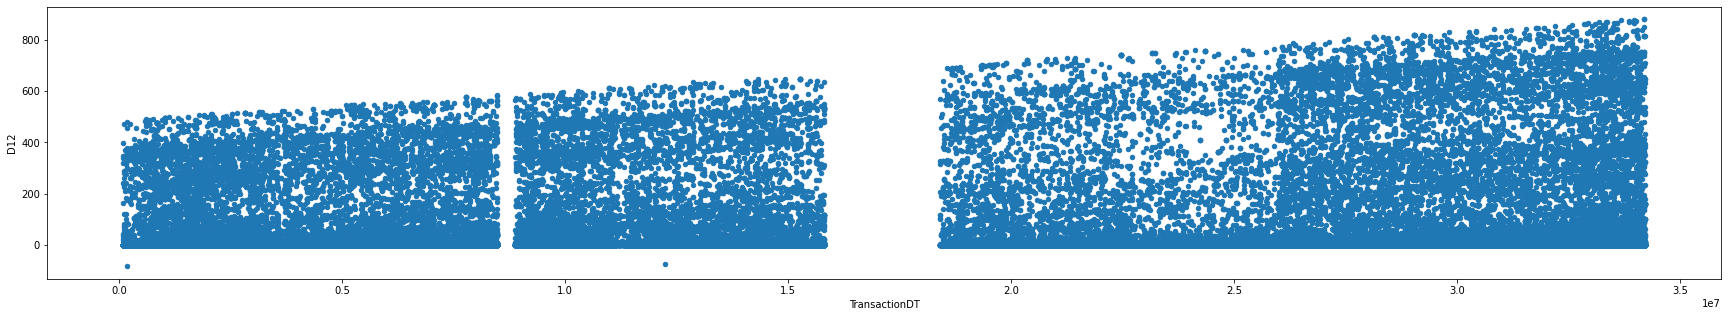

Column  D13


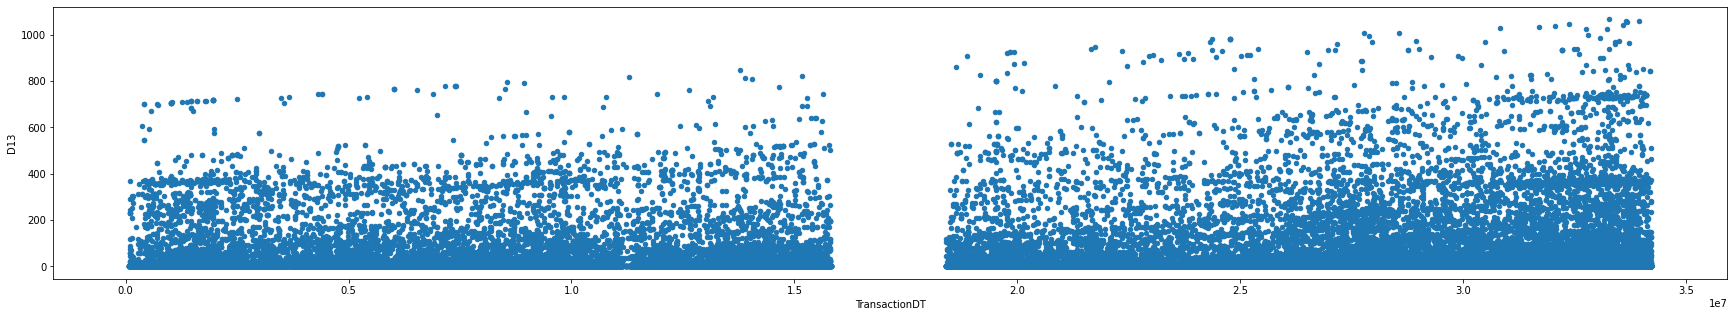

Column  D14


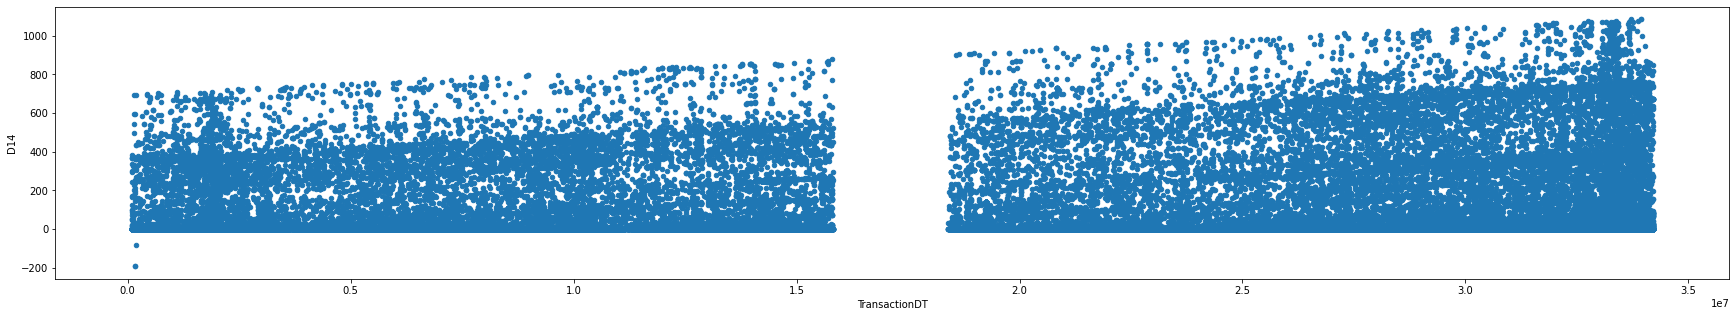

Column  D15


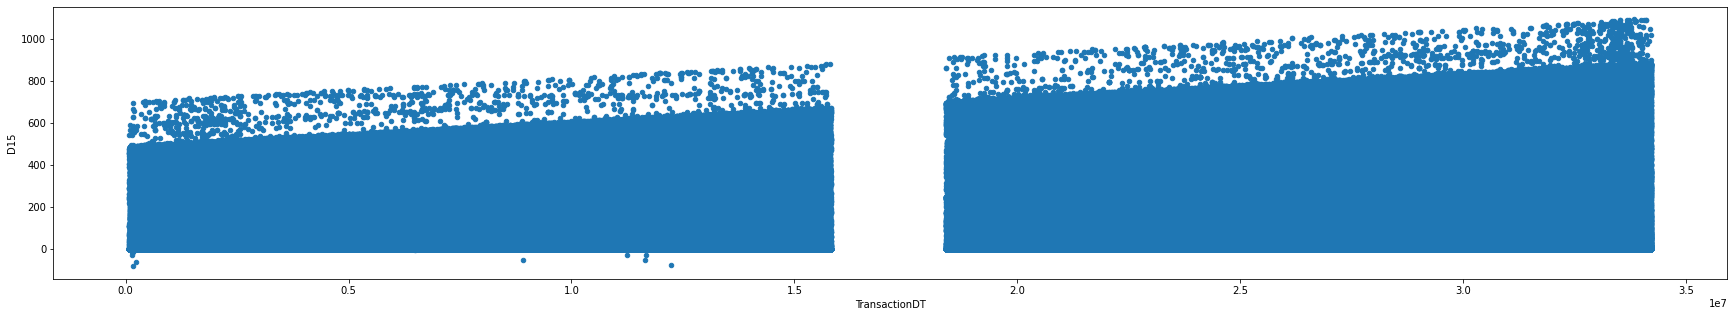

In [ ]:
for d in range(1, 16):
  col = 'D'+str(d)
  print('Column ', col)
  all_trans.plot(x = 'TransactionDT', y = col, kind = 'scatter', figsize = (30, 5))
  plt.show()
  print('=====================================================================================================================================================================================================================')
  


#### Normalize D3~D15 (except D9)

In [ ]:
for d in range(1, 16):
  if d > 2 and d != 9:
    all_trans['D'+str(d)] =  all_trans['D'+str(d)] - all_trans.TransactionDT/np.float32(24*60*60)
    print('D'+str(d), 'normalized')



D3 normalized
D4 normalized
D5 normalized
D6 normalized
D7 normalized
D8 normalized
D10 normalized
D11 normalized
D12 normalized
D13 normalized
D14 normalized
D15 normalized


### 缺失值

我們可以看到有明顯的規律在V欄的缺失值中，接下來我將用Heatmap圖，更進一步檢視V欄中的關係。

In [ ]:
# Input: DataFrame, Output圖的標題，圖的大小, 總資料數，是否水平長條圖輸出

def print_na_ratio(df, title, figure, dfsize, if_h):
    # print missing data ratio of a dataframe
   
    ratio = []
    for col, na in zip(df.columns, df.isnull().sum()):
        r = na/dfsize
        ratio.append(r)      
            
    plt.figure(figsize= figure)
    
    if if_h == True:
        plt.barh(y = list(df.columns), width = ratio)  
        plt.axvline(x= 0.5, linestyle = '--', color='r' )
        plt.ylim([df.columns[0], df.columns[-1]])    
    else:
        plt.bar(x = list(df.columns), height = ratio)  
        plt.axhline( y = 0.5, linestyle = '--', color='r' )
        plt.xlim([df.columns[0], df.columns[-1]])                
    
    
    plt.title(title)
    
    plt.show()


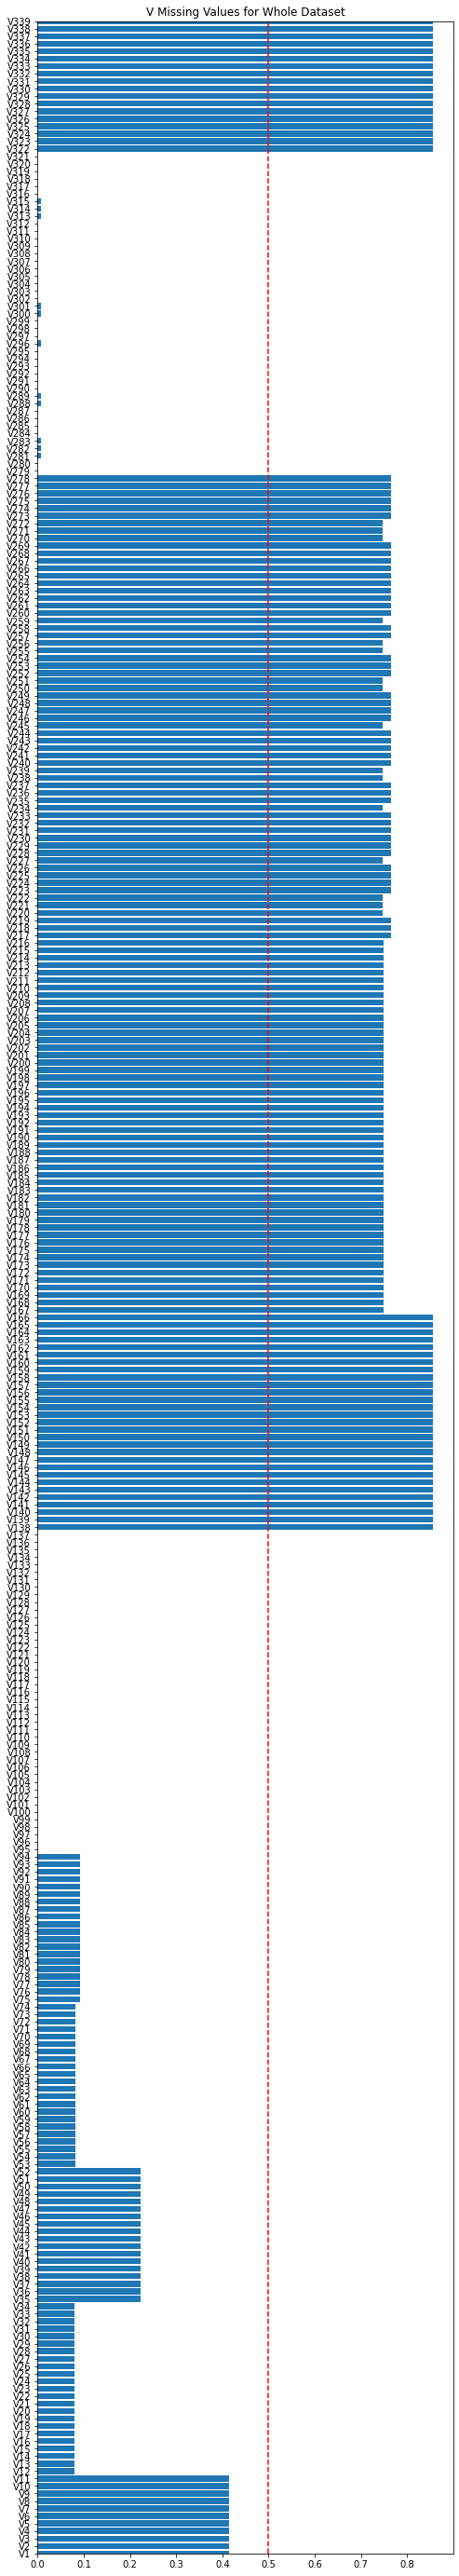

In [ ]:
print_na_ratio(all_trans.iloc[:, 54:], 'V Missing Values for Whole Dataset', (8, 50), all_trans.shape[0],True)

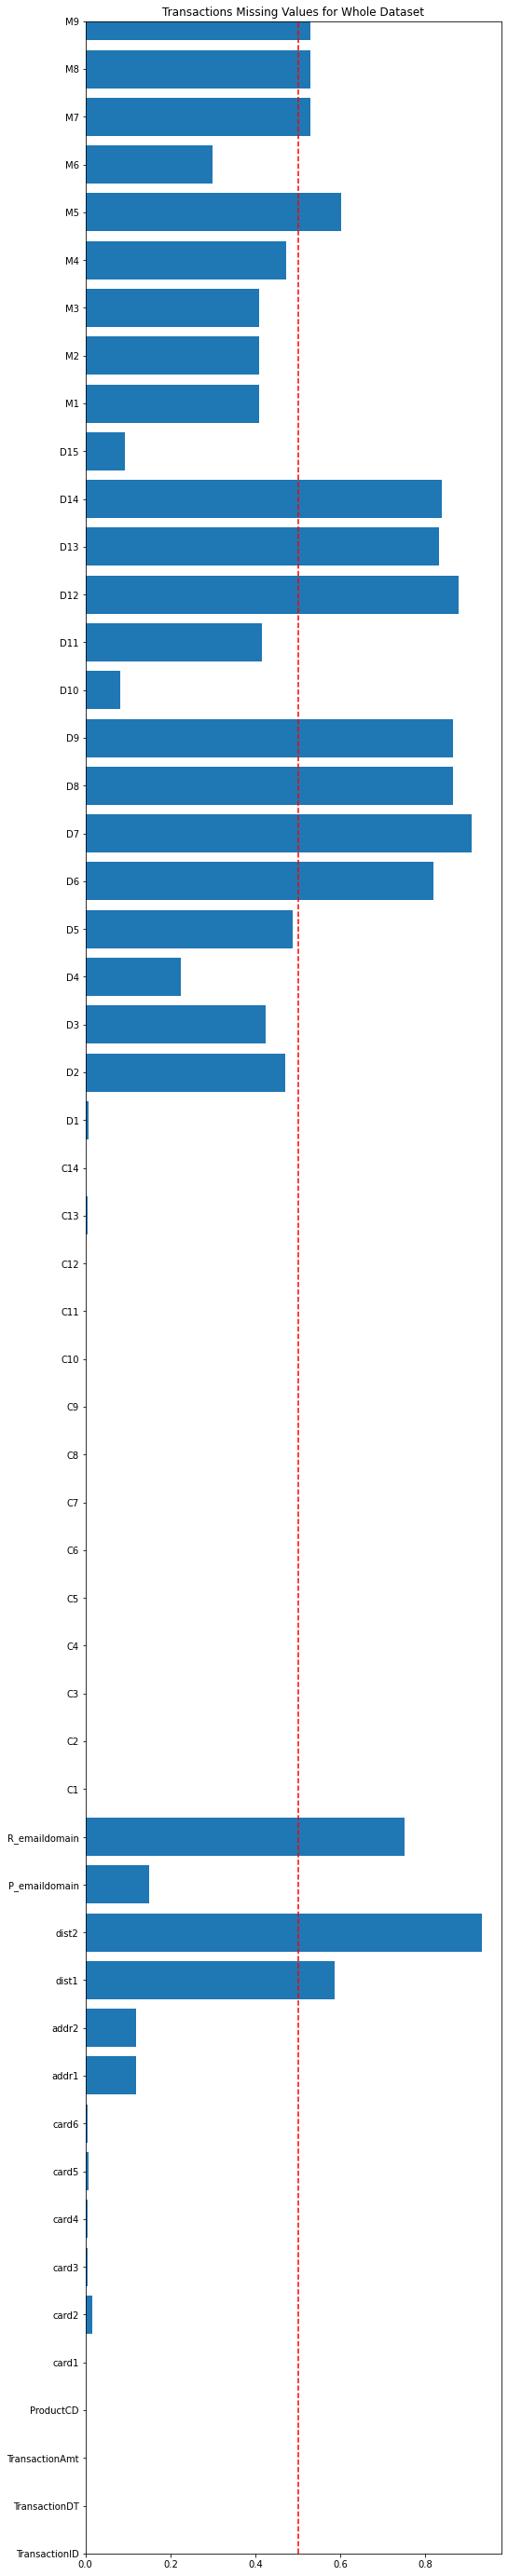

In [ ]:
print_na_ratio(all_trans.iloc[:,:54], 'Transactions Missing Values for Whole Dataset', (8, 50),all_trans.shape[0],True)

### 用Heatmap，根據缺失值的規律，更進一步查看V columns 間的關係。

V2~ V9間有相關, 因此採用V1, V2。

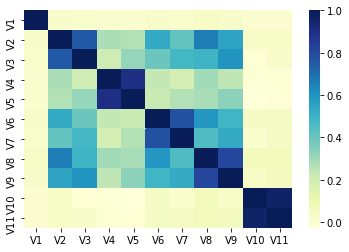

In [ ]:
sns.heatmap(all_trans.iloc[:, 54:65].corr(), cmap="YlGnBu")
plt.show()

因為V12~ V34中的缺失值不高，所以將全部採用。



採用V37, V40, V52

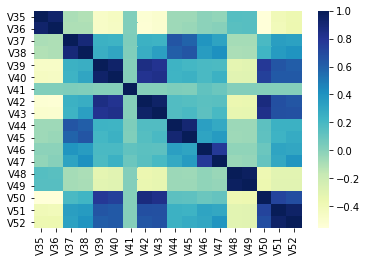

In [ ]:
sns.heatmap(all_trans.iloc[:, 88:106].corr(), cmap="YlGnBu")
plt.show()

因為V53~ V137中的缺失值不高，所以將全部採用。

採用 V138, V140, V158, V164

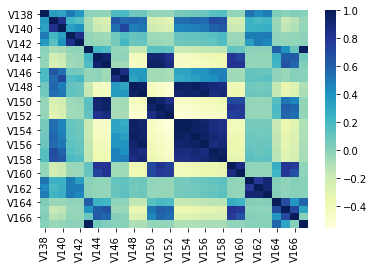

In [ ]:
sns.heatmap(all_trans.iloc[:, 191:221].corr(), cmap="YlGnBu")
plt.show()

採用 V168, 177, 186, 191, 195, 202, 211, 217, 226, 242, 229, 263

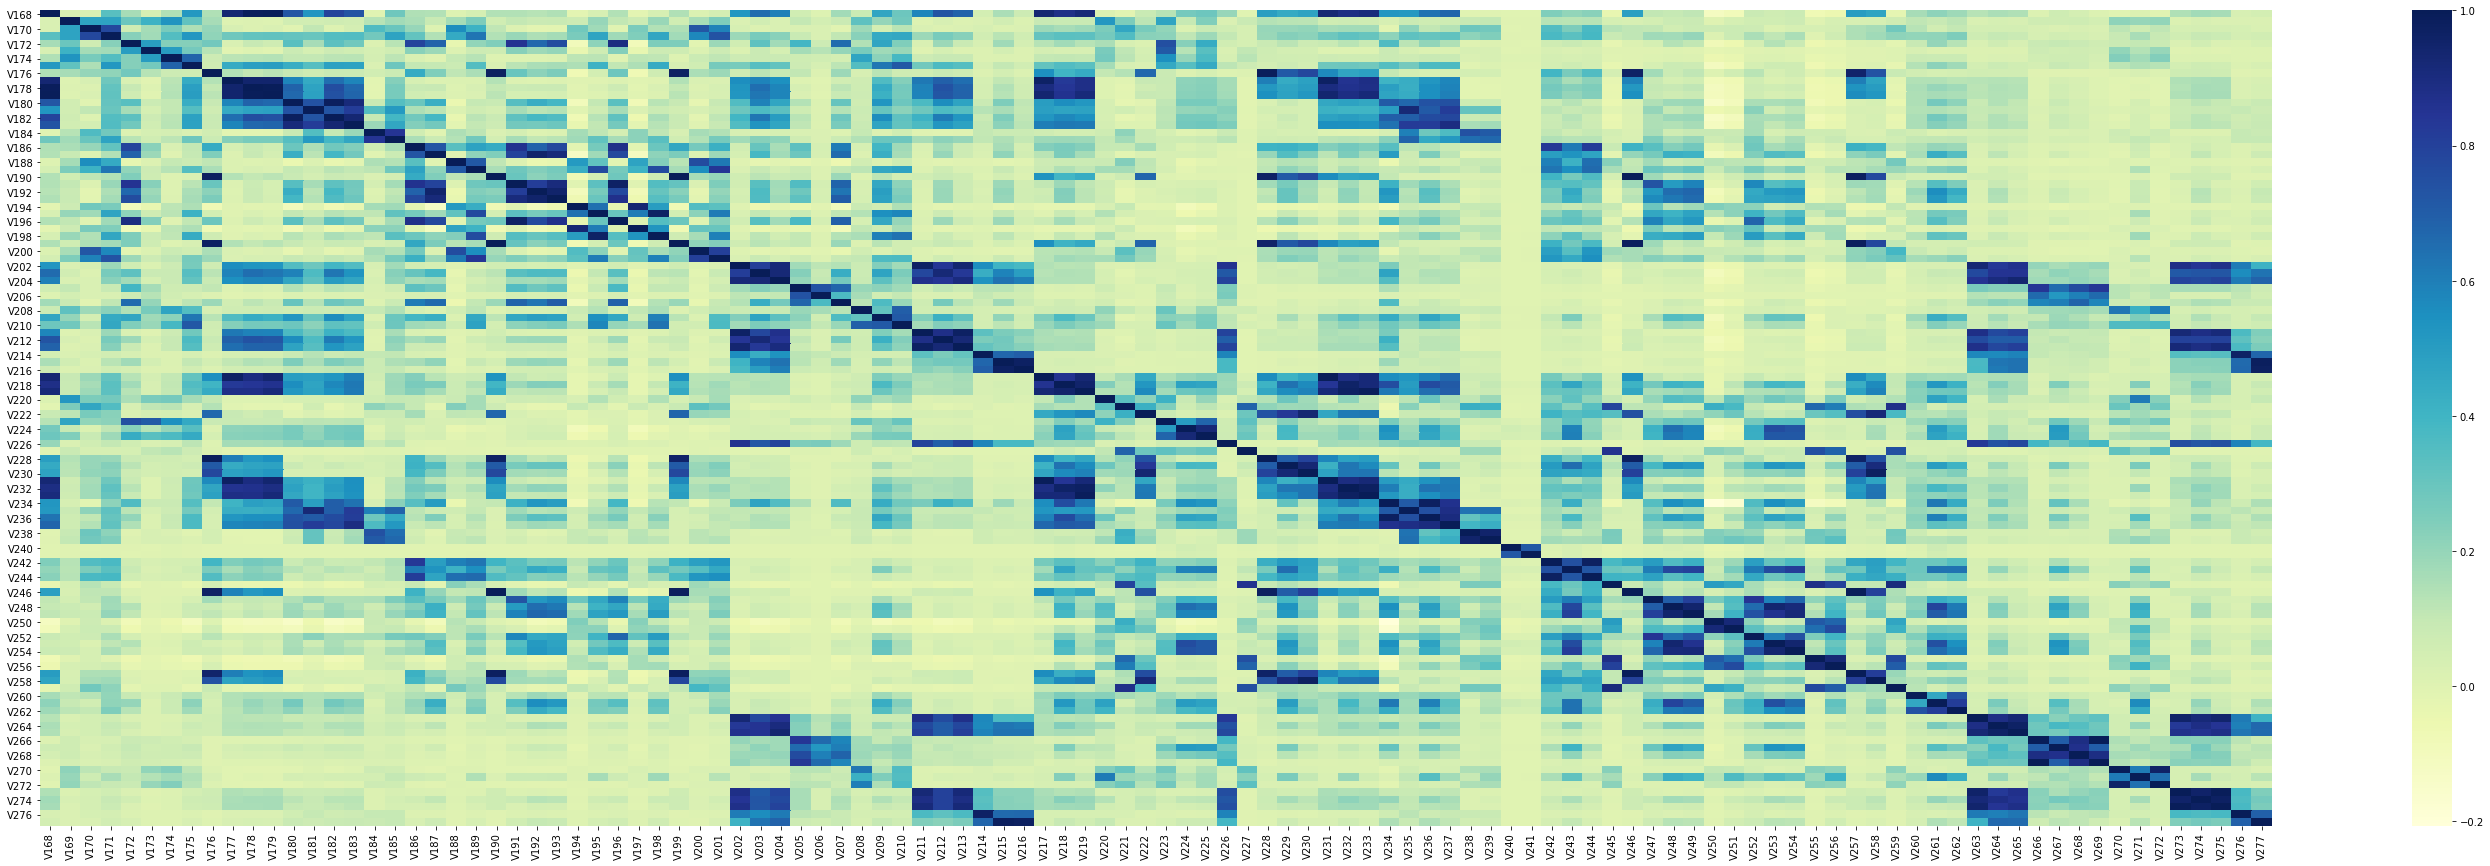

In [ ]:
fig, ax = plt.subplots(figsize = (50, 15))
ax = sns.heatmap(all_trans.iloc[:, 221:331].corr(), cmap="YlGnBu")

plt.show()

因為V279 ~ V321中的缺失值幾乎為0，所以將全部採用。

採用V322, V331

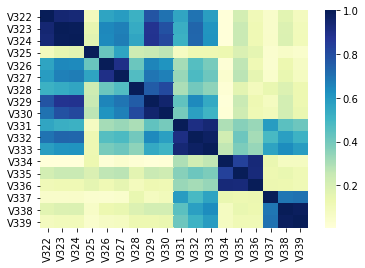

In [ ]:
sns.heatmap(all_trans.iloc[:, 375:].corr(), cmap="YlGnBu")
plt.show()

#### 總結，關於V columns, 採用以下:
 V1, V2, V10, V12~ V34, V37, V40, V52, V53 ~ V137, V138, V140, V158, V164, V168, V177, V186, V191, V195, V202, V211, V217, V226, V242, V229, V263, V279 ~ V321, V322, V331

###  其他的 categoriacal columns (ProductCD , card, addr1, 2, M, P_emaildomain, V12, V13, V14, V88, V94)

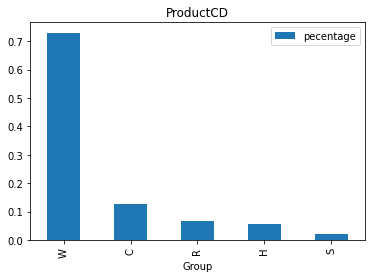

In [ ]:
# print 前二十占比的組

df = turn_into_countdf(all_trans, 'ProductCD')
df.iloc[:20,:].plot(x = 'index', y = 'pecentage',  kind = 'bar', title = 'ProductCD')
plt.xlabel('Group')
plt.show()

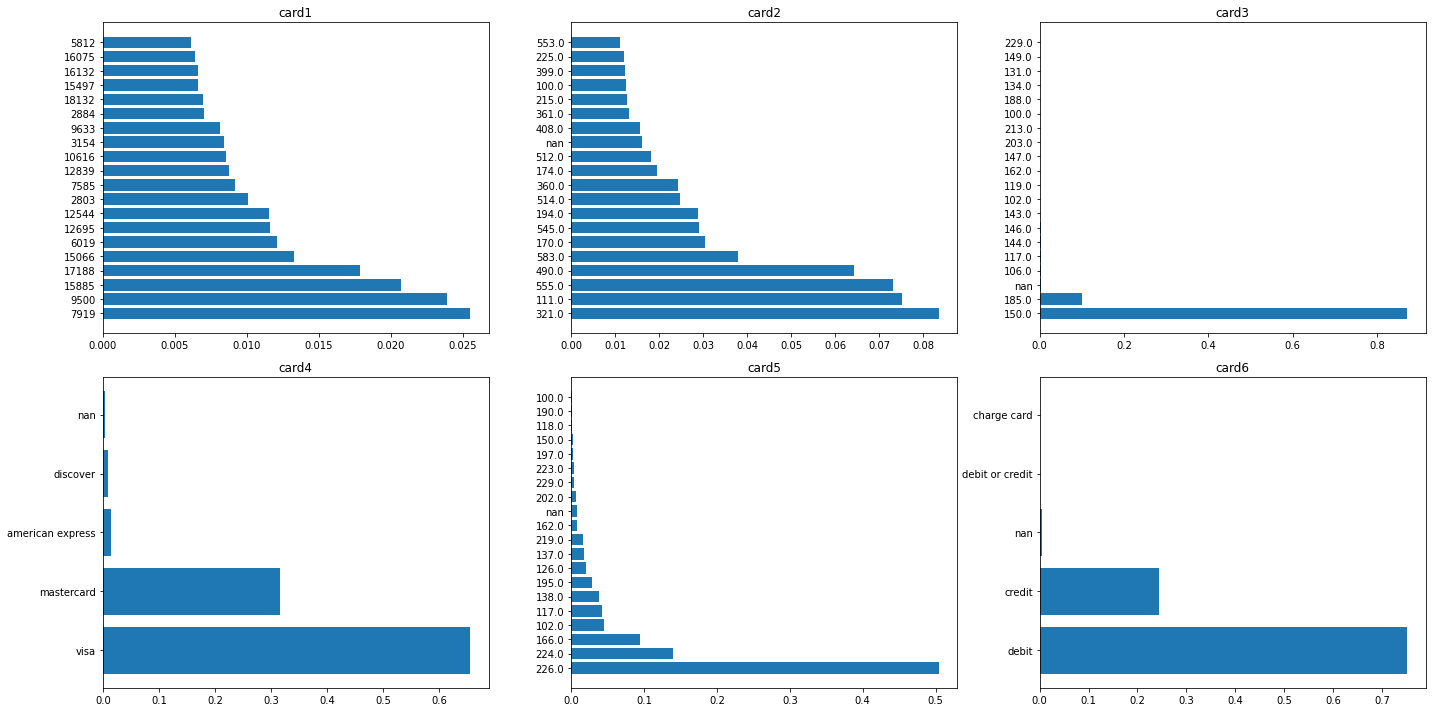

In [ ]:
card_cols = [col for col in all_trans.columns if 'card' in col]

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))

row, c = 0, 0

for col in card_cols:

  if c > 2:
    row = 1
    c = 0

  df = turn_into_countdf(all_trans, col)

  axes[row][c].barh(y = df.iloc[:20, :]['index'].astype('str'), width= df.iloc[:20, :]['pecentage'])
  axes[row][c].title.set_text(col)

  c += 1

plt.tight_layout(w_pad = 0.5)
plt.show()

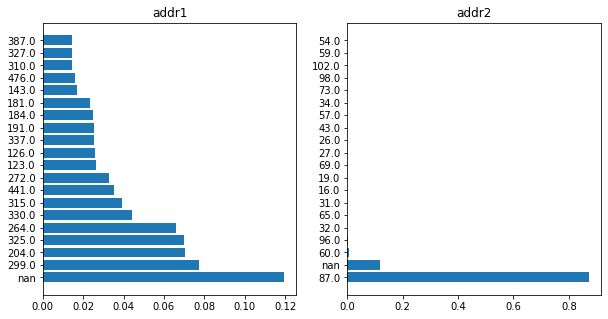

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize = (10, 5))

df1 = turn_into_countdf(all_trans, 'addr1')
axes[0].barh(y = df1.iloc[:20, :]['index'].astype('str'), width= df1.iloc[:20, :]['pecentage'])
axes[0].title.set_text('addr1')

df2 = turn_into_countdf(all_trans, 'addr2')
axes[1].barh(y = df2.iloc[:20, :]['index'].astype('str'), width= df2.iloc[:20, :]['pecentage'])
axes[1].title.set_text('addr2')

plt.show()

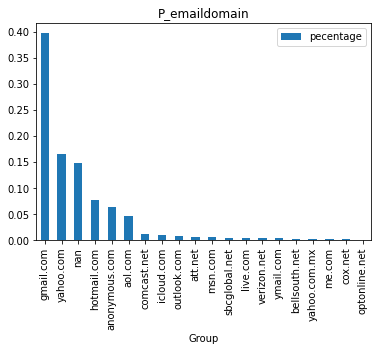

In [ ]:
df = turn_into_countdf(all_trans, 'P_emaildomain')
df.iloc[:20,:].plot(x = 'index', y = 'pecentage',  kind = 'bar', title = 'P_emaildomain')
plt.xlabel('Group')
plt.show()

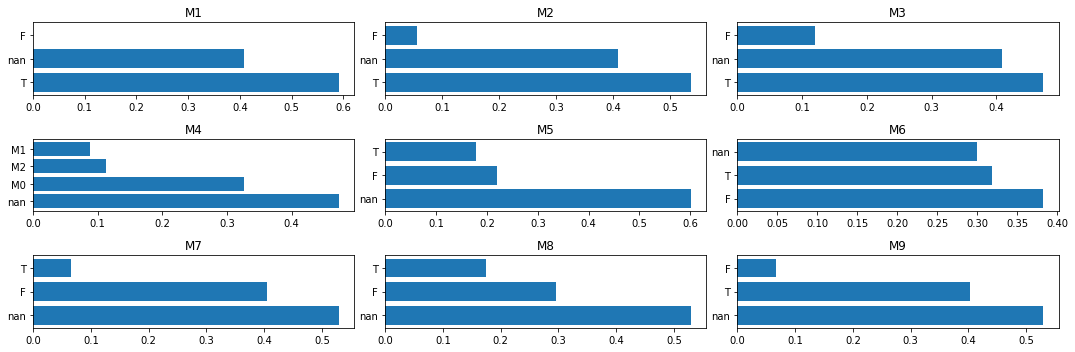

In [ ]:
m_cols = [col for col in all_trans.columns if 'M' in col]

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 5))

row, c = 0, 0

for col in m_cols:
  

  if c >= 3:
    row += 1
    c = 0

  df = turn_into_countdf(all_trans, col)

  axes[row][c].barh(y = df['index'].astype('str'), width= df['pecentage'])
  axes[row][c].title.set_text(col)

  c += 1

plt.tight_layout(w_pad = 0.5)
plt.show()

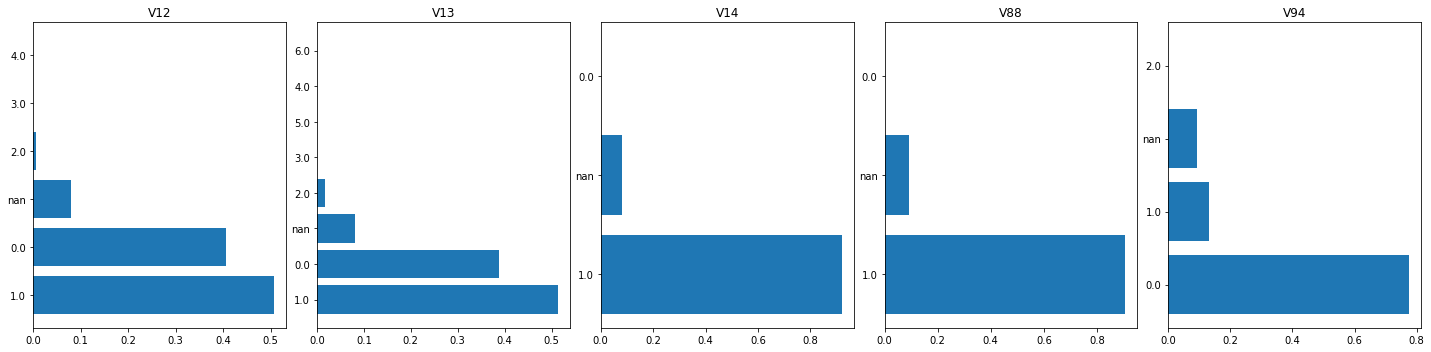

In [ ]:
v_cols = ['V12', 'V13', 'V14', 'V88', 'V94']

fig, axes = plt.subplots(ncols = 5, figsize = (20, 5))

c = 0
for col in v_cols:

  df = turn_into_countdf(all_trans, col)

  axes[c].barh(y = df.iloc[:20, :]['index'].astype('str'), width= df.iloc[:20, :]['pecentage'])
  axes[c].title.set_text(col)

  c += 1

plt.tight_layout(w_pad = 0.5)
plt.show()

# Encoding ProductCD , card, addr1, 2, M, P_emaildomain, V12, V13, V14, V88, V94 columns

In [ ]:
# Input: DataFrame, 用甚麼填補Na, column, 建幾個dummy columns, 是否drop first
# Output: DataFrame填補空值後，加dummy variables


def fillna_getdummy(maindf, na, column, n_dummies, dropfirst ):
    
    print('Before filling NaN:', maindf[column].isnull().sum())
    print('DF shape:', maindf.shape)
    
    
    maindf[column] = maindf[column].fillna(na)
    
    rank = maindf[column].value_counts().index
    
    df = pd.get_dummies(maindf[column])[rank[:n_dummies]]
    
    if dropfirst == True:
        df = df.iloc[:, 1:]
    else:
        pass
    
    df.columns = [str(col) +'_'+str(column) for col in df.columns]
    
    maindf = maindf.drop(columns = column)
    
    output = pd.concat([maindf, df], axis = 1)
    
    print('==========================================')
    print('After filling NaN and getting dummies:', output.shape)
    print('New columns: ', df.columns)
    
    
    return output
    

In [ ]:
# get copy of all_id & all_trans

feature_trans = all_trans.copy()

#### One hot encoding with many categories based on top frequencies

In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='ProductCD',n_dummies=5, na='ProductCD_NA', dropfirst=True )

Before filling NaN: 0
DF shape: (1097231, 393)
After filling NaN and getting dummies: (1097231, 396)
New columns:  Index(['C_ProductCD', 'R_ProductCD', 'H_ProductCD', 'S_ProductCD'], dtype='object')


In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='card3',n_dummies=5, na= 'card3_NA',dropfirst=False)

Before filling NaN: 4567
DF shape: (1097231, 396)
After filling NaN and getting dummies: (1097231, 400)
New columns:  Index(['150.0_card3', '185.0_card3', 'card3_NA_card3', '106.0_card3',
       '117.0_card3'],
      dtype='object')


In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='card4',n_dummies=5, na= 'card4_NA', dropfirst= True)

Before filling NaN: 4663
DF shape: (1097231, 400)
After filling NaN and getting dummies: (1097231, 403)
New columns:  Index(['mastercard_card4', 'american express_card4', 'discover_card4',
       'card4_NA_card4'],
      dtype='object')


In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='card5',n_dummies=20, na= 'card5_NA', dropfirst=False)

Before filling NaN: 8806
DF shape: (1097231, 403)
After filling NaN and getting dummies: (1097231, 422)
New columns:  Index(['226.0_card5', '224.0_card5', '166.0_card5', '102.0_card5',
       '117.0_card5', '138.0_card5', '195.0_card5', '126.0_card5',
       '137.0_card5', '219.0_card5', '162.0_card5', 'card5_NA_card5',
       '202.0_card5', '229.0_card5', '223.0_card5', '197.0_card5',
       '150.0_card5', '118.0_card5', '190.0_card5', '100.0_card5'],
      dtype='object')


In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='card6',n_dummies=5, na= 'card6_NA', dropfirst=True)

Before filling NaN: 4578
DF shape: (1097231, 422)
After filling NaN and getting dummies: (1097231, 425)
New columns:  Index(['credit_card6', 'card6_NA_card6', 'debit or credit_card6',
       'charge card_card6'],
      dtype='object')


In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='P_emaildomain',n_dummies=20, na= 'P_emaildomain_NA', dropfirst=False)

Before filling NaN: 163648
DF shape: (1097231, 425)
After filling NaN and getting dummies: (1097231, 444)
New columns:  Index(['gmail.com_P_emaildomain', 'yahoo.com_P_emaildomain',
       'P_emaildomain_NA_P_emaildomain', 'hotmail.com_P_emaildomain',
       'anonymous.com_P_emaildomain', 'aol.com_P_emaildomain',
       'comcast.net_P_emaildomain', 'icloud.com_P_emaildomain',
       'outlook.com_P_emaildomain', 'att.net_P_emaildomain',
       'msn.com_P_emaildomain', 'sbcglobal.net_P_emaildomain',
       'live.com_P_emaildomain', 'verizon.net_P_emaildomain',
       'ymail.com_P_emaildomain', 'bellsouth.net_P_emaildomain',
       'yahoo.com.mx_P_emaildomain', 'me.com_P_emaildomain',
       'cox.net_P_emaildomain', 'optonline.net_P_emaildomain'],
      dtype='object')


In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='addr2',n_dummies=5, na= 'addr2_NA', dropfirst=False)

Before filling NaN: 131315
DF shape: (1097231, 444)
After filling NaN and getting dummies: (1097231, 448)
New columns:  Index(['87.0_addr2', 'addr2_NA_addr2', '60.0_addr2', '96.0_addr2',
       '32.0_addr2'],
      dtype='object')


In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='V12',n_dummies=6, na= 'V12_NA', dropfirst=True)

Before filling NaN: 88662
DF shape: (1097231, 448)
After filling NaN and getting dummies: (1097231, 452)
New columns:  Index(['0.0_V12', 'V12_NA_V12', '2.0_V12', '3.0_V12', '4.0_V12'], dtype='object')


In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='V13',n_dummies=7, na= 'V13_NA', dropfirst=False)

Before filling NaN: 88662
DF shape: (1097231, 452)
After filling NaN and getting dummies: (1097231, 458)
New columns:  Index(['1.0_V13', '0.0_V13', 'V13_NA_V13', '2.0_V13', '3.0_V13', '5.0_V13',
       '4.0_V13'],
      dtype='object')


In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='V14',n_dummies=7, na= 'V14_NA', dropfirst=True)

Before filling NaN: 88662
DF shape: (1097231, 458)
After filling NaN and getting dummies: (1097231, 459)
New columns:  Index(['V14_NA_V14', '0.0_V14'], dtype='object')


In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='V88',n_dummies=7, na= 'V88_NA', dropfirst=True)

Before filling NaN: 101245
DF shape: (1097231, 459)
After filling NaN and getting dummies: (1097231, 460)
New columns:  Index(['V88_NA_V88', '0.0_V88'], dtype='object')


In [ ]:
feature_trans = fillna_getdummy(maindf= feature_trans, column='V94',n_dummies=7, na= 'V94_NA', dropfirst=True)

Before filling NaN: 101245
DF shape: (1097231, 460)
After filling NaN and getting dummies: (1097231, 462)
New columns:  Index(['1.0_V94', 'V94_NA_V94', '2.0_V94'], dtype='object')


In [ ]:
for i in feature_trans.columns:
  if 'M' in i:
    feature_trans = fillna_getdummy(maindf= feature_trans, column= i ,n_dummies=3, na= i+'_NA', dropfirst=True)


Before filling NaN: 447739
DF shape: (1097231, 462)
After filling NaN and getting dummies: (1097231, 463)
New columns:  Index(['M1_NA_M1', 'F_M1'], dtype='object')
Before filling NaN: 447739
DF shape: (1097231, 463)
After filling NaN and getting dummies: (1097231, 464)
New columns:  Index(['M2_NA_M2', 'F_M2'], dtype='object')
Before filling NaN: 447739
DF shape: (1097231, 464)
After filling NaN and getting dummies: (1097231, 465)
New columns:  Index(['M3_NA_M3', 'F_M3'], dtype='object')
Before filling NaN: 519189
DF shape: (1097231, 465)
After filling NaN and getting dummies: (1097231, 466)
New columns:  Index(['M0_M4', 'M2_M4'], dtype='object')
Before filling NaN: 660114
DF shape: (1097231, 466)
After filling NaN and getting dummies: (1097231, 467)
New columns:  Index(['F_M5', 'T_M5'], dtype='object')
Before filling NaN: 328299
DF shape: (1097231, 467)
After filling NaN and getting dummies: (1097231, 468)
New columns:  Index(['T_M6', 'M6_NA_M6'], dtype='object')
Before filling NaN: 58

#### 用frequency做encoding 

card1, addr1

In [ ]:
feature_trans['card1'] = feature_trans['card1'].map(feature_trans['card1'].value_counts().to_dict())


In [ ]:
feature_trans['addr1'] = feature_trans['addr1'].map(feature_trans['addr1'].value_counts().to_dict())


In [ ]:
feature_trans['addr1'] = feature_trans['addr1'].fillna(-1)

Drop card2 columns, 因為沒有太多幫助

In [ ]:
feature_trans.drop(columns= ['card2'], inplace = True)


# 為 Numeric transaction data 處理缺失值


In [ ]:
# split whole dataframe back into train and test dataset 

feature_trans_train = feature_trans.iloc[:train_trans.shape[0], :]
feature_trans_test = feature_trans.iloc[train_trans.shape[0]:, :]


# feature_id_train = feature_id.iloc[:train_identity.shape[0], :]
# feature_id_test = feature_id.iloc[train_identity.shape[0]:, :]

print('feature_trans_train: ', feature_trans_train.shape, 
     'feature_trans_test:', feature_trans_test.shape)


feature_trans_train:  (590540, 470) feature_trans_test: (506691, 470)


In [ ]:
feature_trans_train['Label'] = train_trans['isFraud']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### dist1

In [ ]:
feature_trans_train['dist1'] = feature_trans_train['dist1'].fillna(-99)
feature_trans_test['dist1'] = feature_trans_test['dist1'].fillna(-99)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### dist2

In [ ]:
# drop column as too much NAN

print('Before drop, ' ,feature_trans_train.shape)
feature_trans_train = feature_trans_train.drop(columns='dist2')
print('After drop, ',feature_trans_train.shape)

print('================================================================')

print('Before drop, ' ,feature_trans_test.shape)
feature_trans_test = feature_trans_test.drop(columns='dist2')
print('After drop, ',feature_trans_test.shape)

Before drop,  (590540, 471)
After drop,  (590540, 470)
Before drop,  (506691, 470)
After drop,  (506691, 469)


### 'R_emaildomain'


In [ ]:
# drop column as too much NAN

print('Before drop, ' ,feature_trans_train.shape)
feature_trans_train = feature_trans_train.drop(columns='R_emaildomain')
print('After drop, ',feature_trans_train.shape)

print('================================================================')

print('Before drop, ' ,feature_trans_test.shape)
feature_trans_test = feature_trans_test.drop(columns='R_emaildomain')
print('After drop, ',feature_trans_test.shape)

Before drop,  (590540, 470)
After drop,  (590540, 469)
Before drop,  (506691, 469)
After drop,  (506691, 468)


### For testing set, C1~ C12 has 3 missing value,  C13 has 4745 missing value 

In [ ]:
# fillna for test C NAN data 

for i in range(1, 15):
    col = 'C'+str(i)
    if feature_trans_test[col].isnull().sum() > 0:
        print('Test C missing data for ' + col, ': ', feature_trans_test[col].isnull().sum())
        fillwith = -1
        feature_trans_test[col] = feature_trans_test[col].fillna(fillwith)


Test C missing data for C1 :  3
Test C missing data for C2 :  3
Test C missing data for C3 :  3
Test C missing data for C4 :  3
Test C missing data for C5 :  3
Test C missing data for C6 :  3
Test C missing data for C7 :  3
Test C missing data for C8 :  3
Test C missing data for C9 :  3
Test C missing data for C10 :  3
Test C missing data for C11 :  3
Test C missing data for C12 :  3
Test C missing data for C13 :  4748
Test C missing data for C14 :  3


### D columns

In [ ]:
feature_trans_train['D1'] = feature_trans_train['D1'].fillna(-9999999)

In [ ]:
feature_trans_test['D1'] = feature_trans_test['D1'].fillna(-9999999)

In [ ]:
feature_trans_train['D2'] = feature_trans_train['D2'].fillna(-9999999)

feature_trans_test['D2'] = feature_trans_test['D2'].fillna(-9999999)

In [ ]:
# drop column D3 as too much NA

feature_trans_train = feature_trans_train.drop(columns='D3')
feature_trans_test = feature_trans_test.drop(columns='D3')


In [ ]:
feature_trans_train['D4'] = feature_trans_train['D4'].fillna(-9999999)

feature_trans_test['D4'] = feature_trans_test['D4'].fillna(-9999999)


In [ ]:
# drop column D5 as too much NA

feature_trans_train = feature_trans_train.drop(columns='D5')
feature_trans_test = feature_trans_test.drop(columns='D5')


In [ ]:
# drop column D6 as too much NA

feature_trans_train = feature_trans_train.drop(columns='D6')
feature_trans_test = feature_trans_test.drop(columns='D6')


In [ ]:
# drop column D7 as too much NA

feature_trans_train = feature_trans_train.drop(columns='D7')
feature_trans_test = feature_trans_test.drop(columns='D7')


In [ ]:
# drop column D8 as too much NA

feature_trans_train = feature_trans_train.drop(columns='D8')
feature_trans_test = feature_trans_test.drop(columns='D8')


In [ ]:
# drop column D9 as too much NA

feature_trans_train = feature_trans_train.drop(columns='D9')
feature_trans_test = feature_trans_test.drop(columns='D9')


In [ ]:
feature_trans_train['D10'] = feature_trans_train['D10'].fillna(-9999999)

feature_trans_test['D10'] = feature_trans_test['D10'].fillna(-9999999)

In [ ]:
# drop column D11 as too much NA

feature_trans_train = feature_trans_train.drop(columns='D11')
feature_trans_test = feature_trans_test.drop(columns='D11')


In [ ]:
# drop column D12 as too much NA

feature_trans_train = feature_trans_train.drop(columns='D12')
feature_trans_test = feature_trans_test.drop(columns='D12')


In [ ]:
# drop column D13 as too much NA

feature_trans_train = feature_trans_train.drop(columns='D13')
feature_trans_test = feature_trans_test.drop(columns='D13')


In [ ]:
# drop column D14 as too much NA

feature_trans_train = feature_trans_train.drop(columns='D14')
feature_trans_test = feature_trans_test.drop(columns='D14')


In [ ]:
feature_trans_train['D15'] = feature_trans_train['D15'].fillna(-9999999)

feature_trans_test['D15'] = feature_trans_test['D15'].fillna(-9999999)

## V Columns

In [ ]:
# Select V1, V2, V10, V12~ V34, V37, V40, V52, V53~ V137, V138, V140, V158, V164, V168, 177, 186, 191, 195, 202, 211, 217, 226, 242, 229, 263,V279 ~ V321, V322, V331

v_keep = [1, 2, 10] + [i for i in range(12, 35)] + [37, 40, 52] + [i for i in range(53, 138)] + [138, 140, 158, 164, 168, 177, 186, 191, 195, 202, 211, 217, 226, 242,  229, 263, 331] + [i for i in range(279, 323)]


In [ ]:
for i in feature_trans_train.columns:
  if 'V' in i and '_' not in i:
    if int(i[1:]) not in v_keep:
      feature_trans_train.drop(columns=i, inplace=True)
      feature_trans_test.drop(columns=i, inplace=True)
      print('column ', i, 'deleted')

column  V3 deleted
column  V4 deleted
column  V5 deleted
column  V6 deleted
column  V7 deleted
column  V8 deleted
column  V9 deleted
column  V11 deleted
column  V35 deleted
column  V36 deleted
column  V38 deleted
column  V39 deleted
column  V41 deleted
column  V42 deleted
column  V43 deleted
column  V44 deleted
column  V45 deleted
column  V46 deleted
column  V47 deleted
column  V48 deleted
column  V49 deleted
column  V50 deleted
column  V51 deleted
column  V139 deleted
column  V141 deleted
column  V142 deleted
column  V143 deleted
column  V144 deleted
column  V145 deleted
column  V146 deleted
column  V147 deleted
column  V148 deleted
column  V149 deleted
column  V150 deleted
column  V151 deleted
column  V152 deleted
column  V153 deleted
column  V154 deleted
column  V155 deleted
column  V156 deleted
column  V157 deleted
column  V159 deleted
column  V160 deleted
column  V161 deleted
column  V162 deleted
column  V163 deleted
column  V165 deleted
column  V166 deleted
column  V167 deleted
c

In [ ]:
feature_trans_train = feature_trans_train.fillna(-99999)
feature_trans_test = feature_trans_test.fillna(-99999)

# Sampling Technique


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb

from xgboost import XGBClassifier

# performance evaluation

from sklearn.metrics import confusion_matrix

In [ ]:
from collections import Counter

In [ ]:
pip install imbalanced-learn

In [ ]:
# split train & validation

X_train = feature_trans_train.iloc[:, 2:-1]
y_train = feature_trans_train.iloc[:, -1]
X_test = feature_trans_test.iloc[:, 2:]

In [ ]:
print(X_train.shape)
print(X_test.shape)

(590540, 292)
(506691, 292)


## Over-Sampling

In [ ]:
start = time.time()

from imblearn.over_sampling import RandomOverSampler


over_sampler = RandomOverSampler(sampling_strategy= 0.5, random_state= 99)

X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
X_train_over_df = pd.DataFrame(X_train_over)
X_train_over_df.columns = X_train.columns
X_train_over_df.head()

print('=====================================================================')
print('After undersampling: ', Counter(y_train_over))
print('Original: ', Counter(y_train))

print('Running Time :', (time.time() - start)/60, 'mins' )

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After undersampling:  Counter({0: 569877, 1: 284938})
Original:  Counter({0: 569877, 1: 20663})
Running Time : 0.03437950611114502 mins


# Model Hyperparameter

In [ ]:
start_search = time.time()
model = XGBClassifier(n_jobs = -1, tree_method='gpu_hist', random_state= 0)
para = {'max_depth':[3,4,5], 'learning_rate':[0.05, 0.03, 0.01], 'n_estimators':[150, 130],  'gamma':[0.6, 0.7, 0.5]}
hypersearch = RandomizedSearchCV(model, para, random_state= 62, scoring='roc_auc')

hypersearch.fit(X_train_over_df, y_train_over)

print('Finish searching! Running Time: ', (time.time()-start_search)/60, 'mins')

Finish searching! Running Time:  9.424239444732667 mins


In [ ]:
hyper_model = XGBClassifier(gamma= 0.5, learning_rate=0.05, max_depth= 4, n_estimators=150,n_jobs = -1, tree_method='gpu_hist', random_state=0)
hyper_model.fit(X_train_over_df, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [ ]:
hyper_pred = hyper_model.predict_proba(X_test)

hyper_pred_fraud = [f for n, f in hyper_pred]

df = pd.DataFrame({'TransactionID': list(feature_trans_test.iloc[:, 0]), 'isFraud': hyper_pred_fraud})

df.to_csv('hyper_0.5_0.5.csv', index = False)